# This file computes diagonalisation & pre-computes results for use later

## Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
from numpy import save, savez, savez_compressed

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import *

from matplotlib.pyplot import spy

import scipy.constants

In [2]:
import matplotlib.pyplot as plt
# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

## Defining parameters

In [3]:
MOLECULE_STRING = "Na23Cs133"
MOLECULE = Na23Cs133
MOLECULE["a0"] = Rb87Cs133["a0"]
MOLECULE["a2"] = Rb87Cs133["a2"]
N_MAX = 1

B = np.array([1 * 1e-4]) # T
# I = 129 #W/m^2
r = 2.9 * 1e-6 # m

H_BAR = scipy.constants.hbar

I1 = MOLECULE["I1"]
I2 = MOLECULE["I2"]
I1_D = round(2*MOLECULE["I1"])
I2_D = round(2*MOLECULE["I2"])
D_0 = MOLECULE["d0"]

PER_MN = (I1_D+1)*(I2_D+1)
N_STATES = PER_MN * (N_MAX+1)**2

## Diagonalise & Calculate 

In [4]:
H0,Hz,Hdc,Hac = hamiltonian.build_hamiltonians(N_MAX, MOLECULE, zeeman=True, Edc=False, ac=True)

H = (
    +H0[...,None]
    +Hz[...,None]*B
    # +Hac[...,None]*I
    )
H=H.transpose(2,0,1)

In [5]:
ENERGIES_RAW, STATES_RAW = eigh(H)

In [6]:
STATES_RAW.shape

(1, 128, 128)

In [7]:
ENERGIES, STATES, labels_d = calculate.sort_by_state(ENERGIES_RAW, STATES_RAW, N_MAX, MOLECULE)

In [8]:
def label_to_state_no(N,MF_D,k):
    return np.where((LABELS_D[:, 0] == N) & (LABELS_D[:, 1] == MF_D) & (LABELS_D[:, 2] == k))[0][0]

def state_no_to_uncoupled_label(state_no):
    return UNCOUPLED_LABELS_D[state_no]

In [9]:
def label_degeneracy(N,MF_D):
    # Want number of ways of having
    # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
    d=0
    for MN in range(-N,N+1):
        for M_I1_D in range(-I1_D,I1_D+1,2):
            for M_I2_D in range(-I2_D,I2_D+1,2):
                if 2*MN+M_I1_D+M_I2_D == MF_D:
                    d+=1
    return d

In [10]:
labels_d[:,1] *= 2 # Double MF to guarantee int
LABELS_D=(np.rint(labels_d)).astype("int")

In [11]:
dipole_op_zero = calculate.dipole(N_MAX,I1,I2,1,0)
dipole_op_minus = calculate.dipole(N_MAX,I1,I2,1,-1)
dipole_op_plus = calculate.dipole(N_MAX,I1,I2,1,+1)

# Form Tensor Prod'd Matrices

In [12]:
# Tensor product hell time
di0dj0 = np.kron(dipole_op_zero, dipole_op_zero)
dipdjm = np.kron(dipole_op_plus, dipole_op_minus)
dimdjp = np.kron(dipole_op_minus, dipole_op_plus)
dipdjp = np.kron(dipole_op_plus, dipole_op_plus)
dimdjm = np.kron(dipole_op_minus, dipole_op_minus)

In [15]:
a = np.random.rand(3,3) * (7.2342+3.252j)
b = np.random.rand(3,3) * (1.23-4.4341j)
i = np.identity(3)

test1 = np.kron(a,i) @ np.kron(i,b)
test2 = np.kron(a,b)

print(np.allclose(test1,test2))

True


In [13]:
# V_dd = (D_0**2/(4*np.pi*scipy.constants.epsilon_0)) * (1/r**3) * ((di0dj0+(dipdjm+dimdjp)/2)-(3/2)*(dipdjp+dimdjm))
V_dd = (D_0**2/(4*np.pi*scipy.constants.epsilon_0)) * (1/r**3) * (2*di0dj0 + (dimdjp + dipdjm))

In [14]:
N_PAIR_STATES = (32+96)**2
print(N_PAIR_STATES)
COUPLED_LABELS_D = []
COUPLED_LABEL_ENERGY = []

for N1 in range(0, N_MAX + 1):
    F1_D = 2*N1 + I1_D + I2_D
    for MF1_D in range(-F1_D,F1_D+1,2):
        for d1 in range(label_degeneracy(N1,MF1_D)):
            for N2 in range(0, N_MAX + 1):
                F2_D = 2*N2 + I1_D + I2_D
                for MF2_D in range(-F2_D,F2_D+1,2):
                    for d2 in range(label_degeneracy(N2,MF2_D)):
                        COUPLED_LABELS_D.append((N1,MF1_D,d1,N2,MF2_D,d2))
                        COUPLED_LABEL_ENERGY.append((ENERGIES[0,label_to_state_no(N1,MF1_D,d1)]+ENERGIES[0,label_to_state_no(N2,MF2_D,d2)]).real)

COUPLED_LABELS_D = np.array(COUPLED_LABELS_D)
COUPLED_LABEL_ENERGY = np.array(COUPLED_LABEL_ENERGY)

16384


In [15]:
state_index_a = np.where((COUPLED_LABELS_D[:, 0] == 0) 
               & (COUPLED_LABELS_D[:, 1] == 10)
               & (COUPLED_LABELS_D[:, 2] == 0)
               & (COUPLED_LABELS_D[:, 3] == 1)
               & (COUPLED_LABELS_D[:, 4] == 10)
               & (COUPLED_LABELS_D[:, 5] == 2))[0][0]
state_index_b = np.where((COUPLED_LABELS_D[:, 0] == 1) 
               & (COUPLED_LABELS_D[:, 1] == 10)
               & (COUPLED_LABELS_D[:, 2] == 2)
               & (COUPLED_LABELS_D[:, 3] == 0)
               & (COUPLED_LABELS_D[:, 4] == 10)
               & (COUPLED_LABELS_D[:, 5] == 0))[0][0]
print(state_index_a,state_index_b)

4094 16159


In [16]:
H_INT_a = states_pair.conj().T @ (V_dd @ states_pair[:,state_index_a])
H_INT_b = states_pair.conj().T @ (V_dd @ states_pair[:,state_index_b])

NameError: name 'states_pair' is not defined

In [20]:
# Find states
states_pair_a = np.kron(STATES[0,:,label_to_state_no(1,10,2)],STATES[0,:,label_to_state_no(0,10,0)])
states_pair_b = np.kron(STATES[0,:,label_to_state_no(0,10,0)],STATES[0,:,label_to_state_no(1,10,2)])

In [21]:
states_pair_a.shape

(16384,)

In [22]:
(states_pair_a.conj().T @ V_dd @ states_pair_b)/H_BAR

(366.42041238729826+0j)

In [26]:
V_dd[state_index_b,state_index_a]

0j

In [168]:
np.min(H_INT_a/H_BAR)

(-185.47082895921153+0j)

In [169]:
np.max(H_INT_a/H_BAR)

(81.83662401895579+0j)

In [23]:
# desired_transition_energy = np.abs(COUPLED_LABEL_ENERGY[state_index_a] - COUPLED_LABEL_ENERGY[state_index_b])


# j ------
# b ------
    # |
    # |
    # |
    # |
# a ------

detunings_up = np.zeros((N_PAIR_STATES),dtype=np.double)
fidelities_up = np.zeros((N_PAIR_STATES),dtype=np.double)

for j in range(N_PAIR_STATES): # for all off resonant states
    # off_resonant_energy = COUPLED_LABEL_ENERGY[j] # get energy
    detuning_energy_b = COUPLED_LABEL_ENERGY[state_index_a] - COUPLED_LABEL_ENERGY[j]
    # detuning_energy_b = np.abs(COUPLED_LABEL_ENERGY[state_index_b] - COUPLED_LABEL_ENERGY[j])
    
    state_b_coupling = H_INT_b[j]
    # state_b_coupling = H_INT_b[j]
    
    supposed_coupling_b = np.abs(state_b_coupling/detuning_energy_b)
    # supposed_coupling_b = np.abs(state_b_coupling/detuning_energy_a)**2
    
    detunings_up[j] = detuning_energy_b
    fidelities_up[j] = np.log10(supposed_coupling_b)
    
    
detunings_down = np.zeros((N_PAIR_STATES),dtype=np.double)
fidelities_down = np.zeros((N_PAIR_STATES),dtype=np.double)

for j in range(N_PAIR_STATES): # for all off resonant states
    # off_resonant_energy = COUPLED_LABEL_ENERGY[j] # get energy
    detuning_energy_a = COUPLED_LABEL_ENERGY[state_index_b] - COUPLED_LABEL_ENERGY[j]
    # detuning_energy_b = np.abs(COUPLED_LABEL_ENERGY[state_index_b] - COUPLED_LABEL_ENERGY[j])
    
    state_a_coupling = H_INT_a[j]
    # state_b_coupling = H_INT_b[j]
    
    supposed_coupling_a = np.abs(state_a_coupling/detuning_energy_a)
    # supposed_coupling_b = np.abs(state_b_coupling/detuning_energy_a)**2
    
    detunings_down[j] = detuning_energy_a
    fidelities_down[j] = np.log10(supposed_coupling_a)
    


NameError: name 'H_INT_b' is not defined

(-2.0, 2.0)

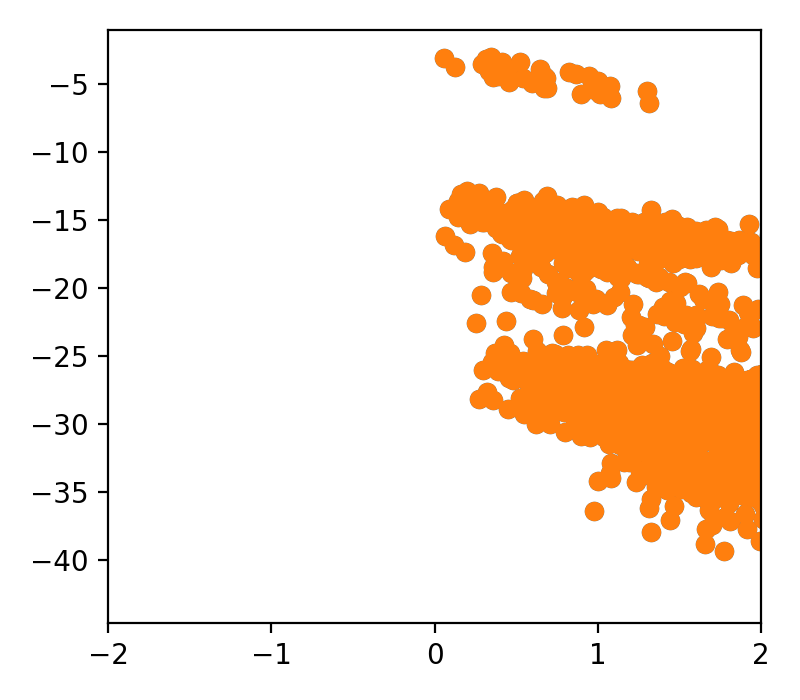

In [115]:
fig,ax = plt.subplots()
ax.scatter(-detunings_up/(1e6*H_BAR),fidelities_up)
ax.scatter(-detunings_up/(1e6*H_BAR),fidelities_up)
ax.set_xlim(-2,2)
# ax.set_ylim(-8,-2)